## Modelagem para Prevenção a Fraudes
<ul>
<li><b>Autor.:</b> Gabriel Nunes Henke</li>
<li><b>Programa:</b> PPGCC - Pós-Graduação em Ciência da Computação</li> 
<li><b>Disciplina:</b> Banco de Dados</li>
<li><b>Programa:</b> Ronaldo Correa</li>
<li><b>Data:</b> 08/06/2022</li>
</ul>


In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

### 1.0 Leitura do dataset

In [106]:
df = pd.read_csv("../data/dataset_online_fraud_detection_2.csv")
df = df.drop('Unnamed: 0', axis =1)

In [108]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
3,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
4,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0


### 2.0 Análise e Exploração dos Dados

In [109]:
df.describe().round()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,308213.0,308213.0,308213.0,308213.0,308213.0,308213.0,308213.0,308213.0
mean,21.0,210286.0,905867.0,885678.0,966479.0,1199288.0,0.0,0.0
std,68.0,533240.0,2873460.0,2869250.0,2402137.0,2638063.0,0.0,0.0
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,10.0,13172.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,12.0,82329.0,20283.0,0.0,76159.0,186567.0,0.0,0.0
75%,14.0,239876.0,205399.0,206475.0,837136.0,1235540.0,0.0,0.0
max,743.0,10000000.0,59585040.0,49585040.0,236230517.0,236726495.0,1.0,1.0


In [110]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [111]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

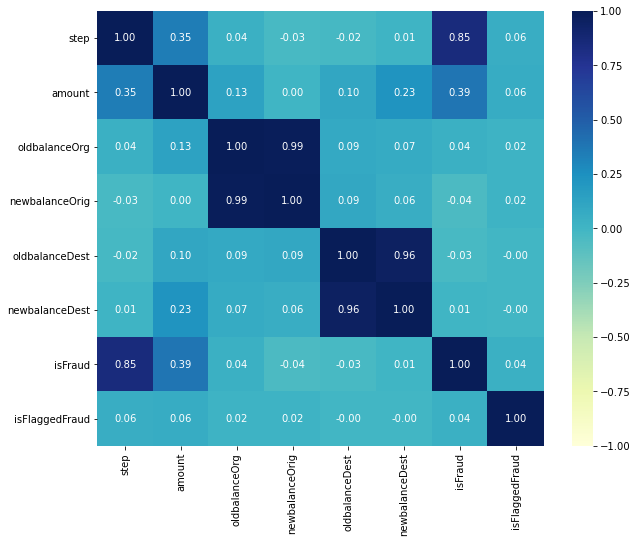

In [112]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=-1);

In [113]:
df.isFraud.value_counts().index

Int64Index([0, 1], dtype='int64')

In [166]:
pd.pivot_table(df, index = 'type',columns = 'isFraud',aggfunc ='count')["amount"][1]

type
CASH_IN        NaN
CASH_OUT    4116.0
DEBIT          NaN
PAYMENT        NaN
TRANSFER    4097.0
Name: 1, dtype: float64

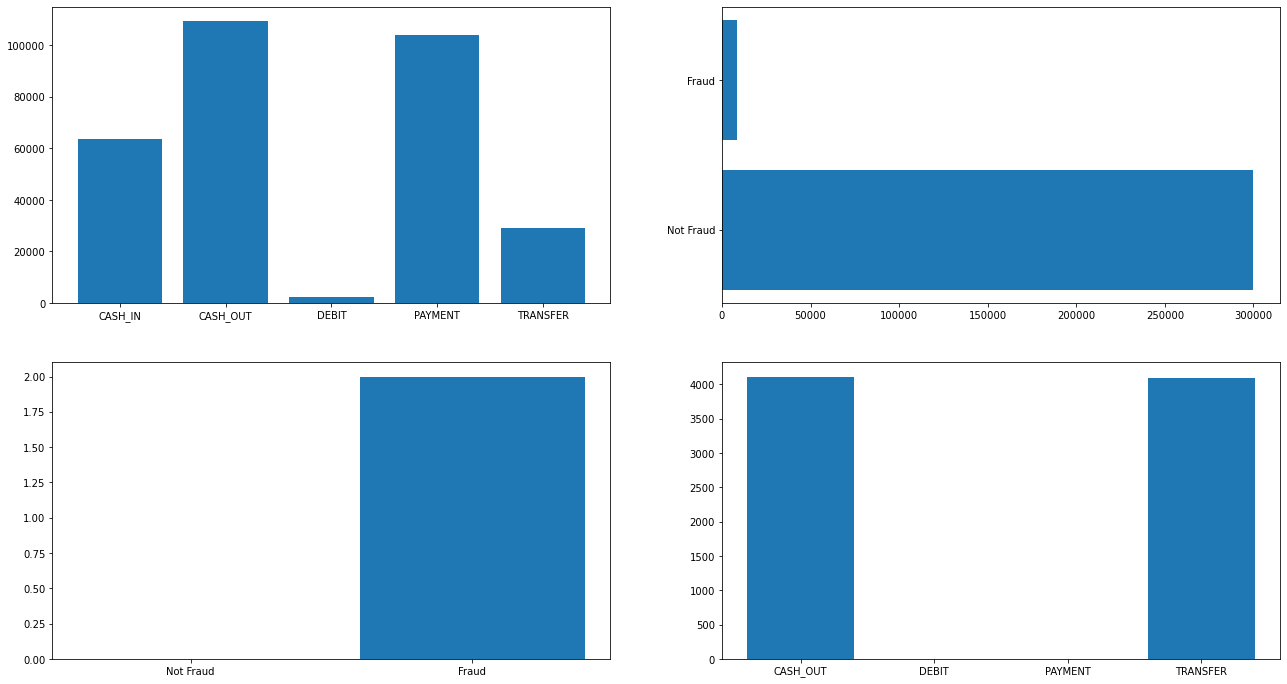

In [167]:
fig, axes = plt.subplots(2, 2, figsize=(22, 12))
ax1 = axes[0, 0].bar(df.groupby(by="type").count()['isFraud'].index, df.groupby(by="type").count()['isFraud'])
ax2 = axes[0, 1].barh(["Not Fraud", "Fraud"], df.isFraud.value_counts())
ax3 = axes[1, 0].bar(["Not Fraud", "Fraud"], df.drop('isFlaggedFraud', axis =1).groupby(by="isFraud").mean()['amount'].round())
ax4 = axes[1, 1].bar(pd.pivot_table(df, index = 'type',columns = 'isFraud',aggfunc ='count')["amount"][1].index, pd.pivot_table(df, index = 'type',columns = 'isFraud',aggfunc ='count')["amount"][1])

In [116]:
df['isFraud'].value_counts()

0    300000
1      8213
Name: isFraud, dtype: int64

array([[<AxesSubplot:title={'center':'step'}>,
        <AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'oldbalanceOrg'}>],
       [<AxesSubplot:title={'center':'newbalanceOrig'}>,
        <AxesSubplot:title={'center':'oldbalanceDest'}>,
        <AxesSubplot:title={'center':'newbalanceDest'}>],
       [<AxesSubplot:title={'center':'isFraud'}>,
        <AxesSubplot:title={'center':'isFlaggedFraud'}>, <AxesSubplot:>]],
      dtype=object)

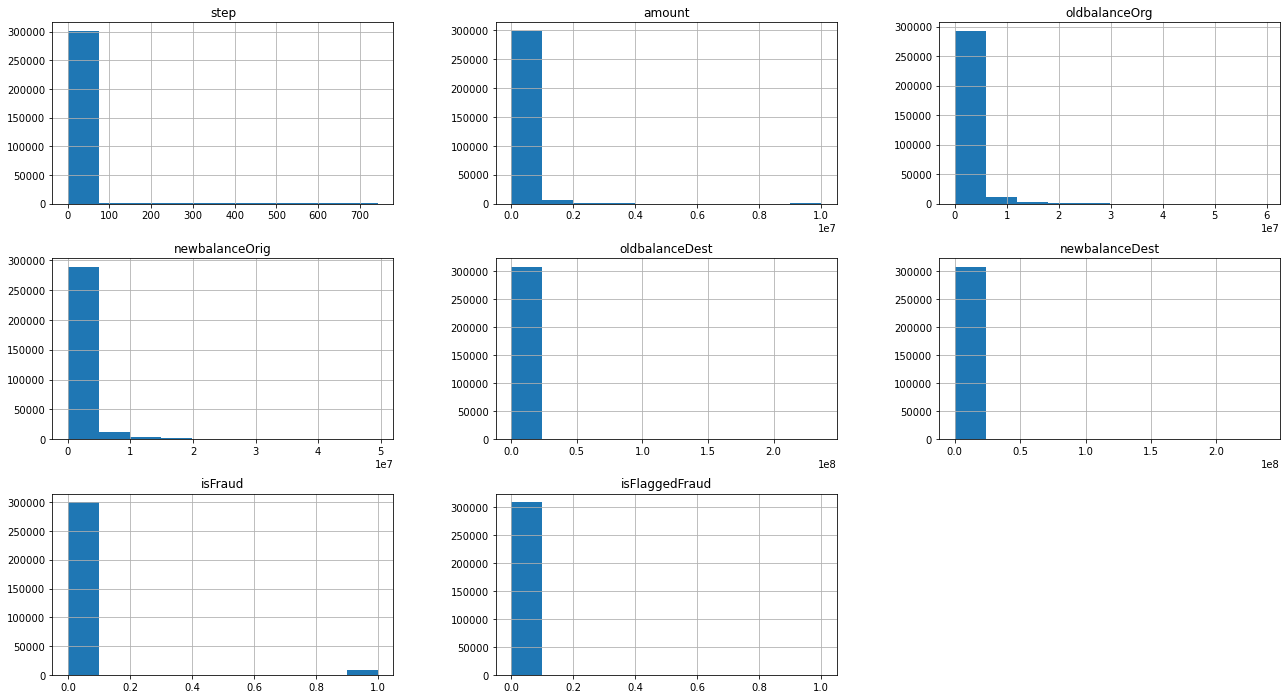

In [117]:
df.round().hist(figsize=(22,12))

### 3.0 Tratamento dos Dados (Pré Processamento)

#### 3.1 Tratamento de Outliers

In [118]:
df.loc[:, ['category_amount']] = pd.cut(df["amount"], bins=3, labels = ["Baixo", "Medio", "Alto"])
df.loc[:, ['category_oldbalanceOrg']] = pd.cut(df["oldbalanceOrg"], bins=3, labels = ["Baixo", "Medio", "Alto"])
df.loc[:, ['category_newbalanceOrig']] = pd.cut(df["newbalanceOrig"], bins=3, labels = ["Baixo", "Medio", "Alto"])
df.loc[:, ['category_oldbalanceDest']] = pd.cut(df["oldbalanceDest"], bins=3, labels = ["Baixo", "Medio", "Alto"])
df.loc[:, ['category_newbalanceDest']] = pd.cut(df["newbalanceDest"], bins=3, labels = ["Baixo", "Medio", "Alto"])

In [119]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,category_amount,category_oldbalanceOrg,category_newbalanceOrig,category_oldbalanceDest,category_newbalanceDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,Baixo,Baixo,Baixo,Baixo,Baixo
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,Baixo,Baixo,Baixo,Baixo,Baixo
2,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,Baixo,Baixo,Baixo,Baixo,Baixo
3,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0,Baixo,Baixo,Baixo,Baixo,Baixo
4,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0,Baixo,Baixo,Baixo,Baixo,Baixo


#### 3.2 Normalizaçao dos dados 

In [120]:
columns_to_be_normalized = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
df[columns_to_be_normalized] = StandardScaler().fit_transform(df[columns_to_be_normalized])

#### 3.3 Excluindo colunas nao necessarias para o treinamento do modelo

In [121]:
df = df.drop(['step', 'nameOrig', 'nameDest'], axis = 1)

#### 3.4 Transformando campos textos em categoricos

In [122]:
df_final = pd.get_dummies(df)

In [123]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308213 entries, 0 to 308212
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   amount                         308213 non-null  float64
 1   oldbalanceOrg                  308213 non-null  float64
 2   newbalanceOrig                 308213 non-null  float64
 3   oldbalanceDest                 308213 non-null  float64
 4   newbalanceDest                 308213 non-null  float64
 5   isFraud                        308213 non-null  int64  
 6   isFlaggedFraud                 308213 non-null  int64  
 7   type_CASH_IN                   308213 non-null  uint8  
 8   type_CASH_OUT                  308213 non-null  uint8  
 9   type_DEBIT                     308213 non-null  uint8  
 10  type_PAYMENT                   308213 non-null  uint8  
 11  type_TRANSFER                  308213 non-null  uint8  
 12  category_amount_Baixo         

In [124]:
### 4.0 Feature Engineering

#### 4.1 Aplicando tecnica de SMOTE para balanceamento do dataset

In [168]:
X = df_final.drop('isFraud', axis=1)
y = df_final['isFraud']

In [169]:
y.value_counts()

0    300000
1      8213
Name: isFraud, dtype: int64

In [170]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [171]:
y_train.value_counts()

0    201153
1    200847
Name: isFraud, dtype: int64

In [172]:
y_test.value_counts()

1    99153
0    98847
Name: isFraud, dtype: int64

### 5.0 Seleçao de Atributos

#### 5.1 Random Forest

In [173]:
%%time
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)

Wall time: 38.5 s


RandomForestClassifier(random_state=42)

In [174]:
y_pred = rf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98847
           1       1.00      1.00      1.00     99153

    accuracy                           1.00    198000
   macro avg       1.00      1.00      1.00    198000
weighted avg       1.00      1.00      1.00    198000



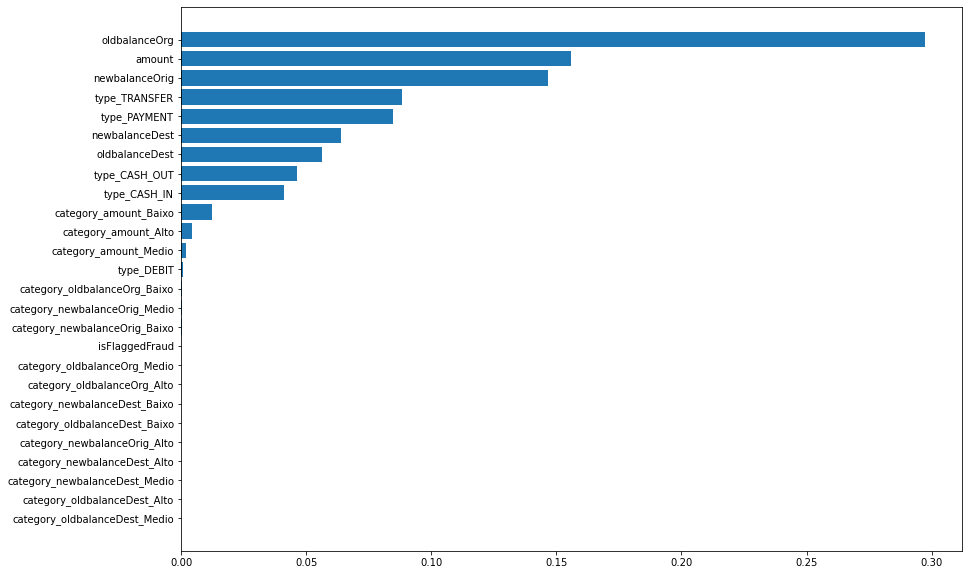

In [175]:
f_i = list(zip(X_train.columns,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])

plt.figure(figsize=(14,10))
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

In [176]:
best_features = ["oldbalanceOrg", "amount", "newbalanceDest", "oldbalanceDest", "type_TRANSFER", "newbalanceOrig", 
                     "category_amount_Baixo", "type_CASH_OUT", "category_amount_Alto", "type_PAYMENT", "category_amount_Medio", "type_CASH_IN"]

### 6.0 Treinamento do modelo preditivo

In [177]:
X = df_final[best_features]
y = df_final['isFraud']

In [178]:
models = [
    ("Random_Forest", RandomForestClassifier(random_state=42)),
    ("Decision_Tree", DecisionTreeClassifier()),
    ("Naive_Bayes", GaussianNB()),
    ("Logistic_Regression", LogisticRegression(max_iter=1000, random_state =0 ))
]

In [179]:
%%time

trained_models = []
results = {'modelo': [], 'acuracia': [], 'precisao': [], 'recall': []}

for name, model in models:
    print(f"Treinando {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    trained_models.append((name, model, metrics.accuracy_score(y_test, y_pred)))
    results['modelo'].append(name)
    results['acuracia'].append(metrics.accuracy_score(y_test, y_pred))
    results['precisao'].append(metrics.precision_score(y_test, y_pred))
    results['recall'].append(metrics.recall_score(y_test, y_pred, average='macro'))

Treinando Random_Forest...
Treinando Decision_Tree...
Treinando Naive_Bayes...
Treinando Logistic_Regression...
Wall time: 1min 6s


In [180]:
df_results = pd.DataFrame(data=results)
df_results

,modelo,acuracia,precisao,recall
0,Random_Forest,0.997753,0.997029,0.997751
1,Decision_Tree,0.997162,0.996285,0.997160
2,Naive_Bayes,0.620475,0.940512,0.621035
3,Logistic_Regression,0.965707,0.942042,0.965665


### 7.0 Validação e avaliação do modelo

<AxesSubplot:xlabel='modelo'>

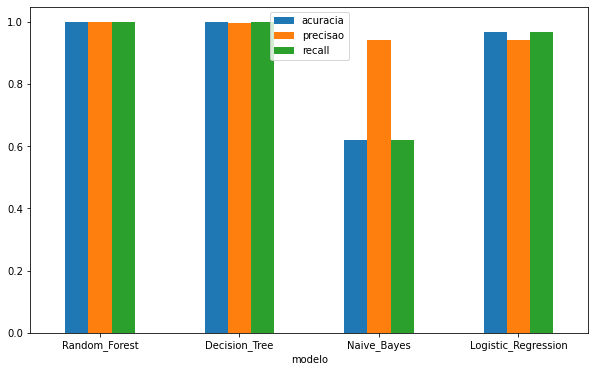

In [181]:
df_results.plot.bar(x="modelo", rot=0, figsize=(10,6))

### 8.0 Exportação do modelo

In [182]:
for model in trained_models:
    filename = f'../models/{model[0]}_{datetime.now().strftime("%Y-%m-%d")}.sav'
    pickle.dump(model, open(filename, 'wb'))